In [101]:
import os
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from keras import layers, models, optimizers

import tensorflow_io as tfio

from sklearn.metrics import confusion_matrix
from seaborn import heatmap
import scipy.signal as signal

# tf.config.run_functions_eagerly(True)

In [102]:
# Load the data

os.chdir('C:\LELEC210X\LELEC210X')

"""
_ = get_file('esc-50.zip',
                        'https://github.com/karoldvl/ESC-50/archive/master.zip',
                        cache_dir='./',
                        cache_subdir='datasets',
                        extract=True)
"""

"\n_ = get_file('esc-50.zip',\n                        'https://github.com/karoldvl/ESC-50/archive/master.zip',\n                        cache_dir='./',\n                        cache_subdir='datasets',\n                        extract=True)\n"

In [103]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=10200)
    return wav

In [104]:
# Current path of the file
curDir = str(os.getcwd())

esc50_csv = curDir+'\classification\src\classification\datasets\ESC-50\meta\esc50.csv'
base_data_path = 'classification/src/classification/datasets/ESC-50/audio'

pd_data = pd.read_csv(esc50_csv)

my_classes = ['chirping_birds', 'chainsaw', 'crackling_fire', 'helicopter', 'hand_saw', 'fireworks']
map_class_to_id  = {label: idx for idx, label in enumerate(my_classes)}

filtered_pd = pd_data[pd_data.category.isin(my_classes)]
unknown_pd = pd_data[~pd_data.category.isin(my_classes)]

class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

unknown_pd = unknown_pd.assign(target=5)

# reduce the number of unknown samples to balance the dataset

unknown_pd = unknown_pd.sample(frac=40/1800, random_state=int(time.time()))
"""
filtered_pd = pd.concat([filtered_pd, unknown_pd])
"""
full_path = filtered_pd['filename'].apply(lambda row: os.path.join(base_data_path, row))
filtered_pd = filtered_pd.assign(filename=full_path)

filenames = filtered_pd['filename']
targets = filtered_pd['target']
folds = filtered_pd['fold']

my_classes = ['chirping_birds', 'chainsaw', 'crackling_fire', 'helicopter', 'hand_saw', 'fireworks']

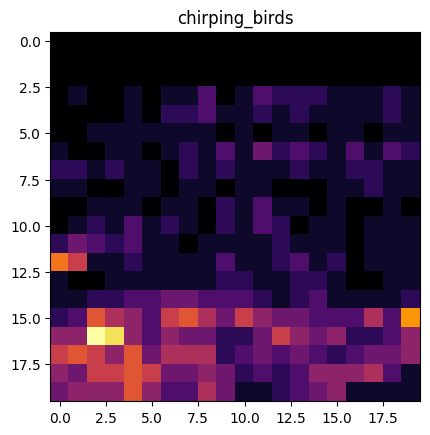

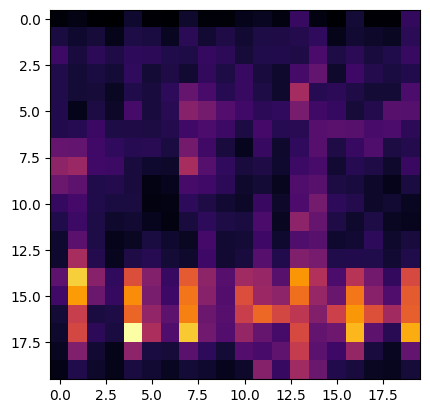

In [105]:
main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets, folds))

@tf.function
def load_wav_for_map(filename, label, fold):
  return load_wav_16k_mono(filename), label, fold

main_ds = main_ds.map(load_wav_for_map)

@tf.function
def apply_time_shift(wav, label, fold):
  shift = tf.random.uniform(shape=[], minval=0, maxval=tf.shape(wav)[0] - 20*512, dtype=tf.int32)
  return wav[shift:shift+20*512], label, fold

main_ds_time_shift_1 = main_ds.map(apply_time_shift)
main_ds_time_shift_2 = main_ds.map(apply_time_shift)
main_ds_time_shift_3 = main_ds.map(apply_time_shift)
main_ds_time_shift_4 = main_ds.map(apply_time_shift)

main_ds = tf.data.Dataset.zip((main_ds_time_shift_1, main_ds_time_shift_2)).flat_map(lambda x, y: tf.data.Dataset.from_tensors(x).concatenate(tf.data.Dataset.from_tensors(y)))
main_ds = tf.data.Dataset.zip((main_ds, main_ds_time_shift_3)).flat_map(lambda x, y: tf.data.Dataset.from_tensors(x).concatenate(tf.data.Dataset.from_tensors(y)))
main_ds = tf.data.Dataset.zip((main_ds, main_ds_time_shift_4)).flat_map(lambda x, y: tf.data.Dataset.from_tensors(x).concatenate(tf.data.Dataset.from_tensors(y)))

@tf.function
def apply_bandpass(wav, label, fold):
  filter = signal.butter(10, [500, 5000], btype='bandpass', fs=10200, output='sos')
  wav = tf.numpy_function(lambda x: signal.sosfilt(filter, x).astype(np.float32), [wav], tf.float32)
  return wav, label, fold

# main_ds_bandpass = main_ds.map(apply_bandpass)
# main_ds = tf.data.Dataset.zip((main_ds, main_ds_bandpass)).flat_map(lambda x, y: tf.data.Dataset.from_tensors(x).concatenate(tf.data.Dataset.from_tensors(y)))

@tf.function
def apply_noise(wav, label, fold):
  # get wav energy
  energy = tf.reduce_sum(wav ** 2) / tf.cast(tf.shape(wav)[0], tf.float32)
  # add gaussian noise
  noise = tf.random.normal(tf.shape(wav), stddev=energy * 0.1)
  return wav + noise, label, fold

main_ds = main_ds.map(apply_noise)

# plot the first 9 waveforms with time shift
"""
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, (wav, label, fold) in enumerate(main_ds.take(9)):
  r, c = i // 3, i % 3
  ax = axes[r, c]
  ax.plot(wav.numpy())
  ax.set_title(my_classes[label.numpy()])
  ax.axis('off')
plt.show()
"""

# apply a melspectrogram transformation to the audio data

@tf.function
def wav2spec(wav, label, fold):
  spectrogram = tfio.audio.spectrogram(wav, nfft=512, window=256, stride=512)
  mel_spectrogram = tfio.audio.melscale(spectrogram, rate=12000, mels=20, fmin=0, fmax=6000)
  mel_spectrogram = tf.expand_dims(mel_spectrogram, -1)  # Ensure 3 dimensions
  mel_spectrogram = tf.image.rot90(mel_spectrogram, k=-1)
  return mel_spectrogram, label, fold

main_ds = main_ds.map(wav2spec)

@tf.function
def float_to_quint16(spec, label, fold):
  return tf.cast(spec, tf.uint16), label, fold

main_ds = main_ds.map(float_to_quint16)

# plot the first 9 spectrograms

spec, label, fold = next(iter(main_ds.take(1)))
plt.imshow(spec.numpy(), cmap='inferno')
plt.title(my_classes[label.numpy()])
plt.show()

"""
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, (spec, label, fold) in enumerate(main_ds.take(9)):
  r, c = i // 3, i % 3
  ax = axes[r, c]
  ax.imshow(spec.numpy(), cmap='inferno')
  ax.set_title(my_classes[label.numpy()])
  ax.axis('off')
plt.show()
"""
file1 = np.load("classification/data/melspecs/0005001a00.npy")
plt.imshow(file1.reshape(20, 20), cmap='inferno')
plt.show()

# split the dataset into training and validation sets

@tf.function
def is_validation(fold):
  return fold == 1

@tf.function
def is_test(fold):
  return fold == 2

train_ds = main_ds.filter(lambda wav, label, fold: not is_validation(fold) and not is_test(fold))
val_ds = main_ds.filter(lambda wav, label, fold: is_validation(fold))
test_ds = main_ds.filter(lambda wav, label, fold: is_test(fold))

# shuffle the training dataset

train_ds = train_ds.shuffle(buffer_size=1000, reshuffle_each_iteration=True)

# batch the datasets

train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)
test_ds = test_ds.batch(32)

# prepare the datasets for training

train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)
test_ds = test_ds.prefetch(tf.data.experimental.AUTOTUNE)


In [106]:

# build the model

def build_model(input_shape):
  model = models.Sequential()
  model.add(layers.Input(shape=input_shape))
  model.add(layers.Lambda(lambda x: x / tf.reduce_max(x)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.2))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(6, activation='softmax'))
  return model

input_shape = (20, 20, 1)

model = build_model(input_shape)

# compile the model

model.compile(optimizer=optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'], 
              weighted_metrics=[])

model_path = r'C:\LELEC210X\LELEC210X\classification\data\models\four.keras'

model = models.load_model(model_path)

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_3 (Lambda)           (None, 20, 20, 1)         0         
                                                                 
 conv2d_15 (Conv2D)          (None, 18, 18, 32)        320       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 9, 9, 32)         0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 9, 9, 32)          0         
                                                                 
 conv2d_16 (Conv2D)          (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 3, 3, 64)         0         
 g2D)                                                

Epoch 1/10
6/6 [==============================] - 12s 1s/step - loss: 2.4574 - accuracy: 0.7619 - val_loss: 0.9270 - val_accuracy: 0.6250
Epoch 2/10
6/6 [==============================] - 11s 1s/step - loss: 2.8340 - accuracy: 0.6845 - val_loss: 1.0624 - val_accuracy: 0.5938
Epoch 3/10
6/6 [==============================] - 12s 1s/step - loss: 3.2174 - accuracy: 0.6726 - val_loss: 1.0780 - val_accuracy: 0.5938
Epoch 4/10
6/6 [==============================] - 12s 1s/step - loss: 2.7408 - accuracy: 0.6964 - val_loss: 1.0766 - val_accuracy: 0.6146
Epoch 5/10
6/6 [==============================] - 13s 1s/step - loss: 2.8570 - accuracy: 0.7024 - val_loss: 1.0230 - val_accuracy: 0.6406
Epoch 6/10
6/6 [==============================] - 12s 1s/step - loss: 2.8078 - accuracy: 0.7143 - val_loss: 1.2136 - val_accuracy: 0.5573
Epoch 7/10
6/6 [==============================] - 12s 1s/step - loss: 3.2140 - accuracy: 0.6488 - val_loss: 1.1199 - val_accuracy: 0.5625
Epoch 8/10
6/6 [==================

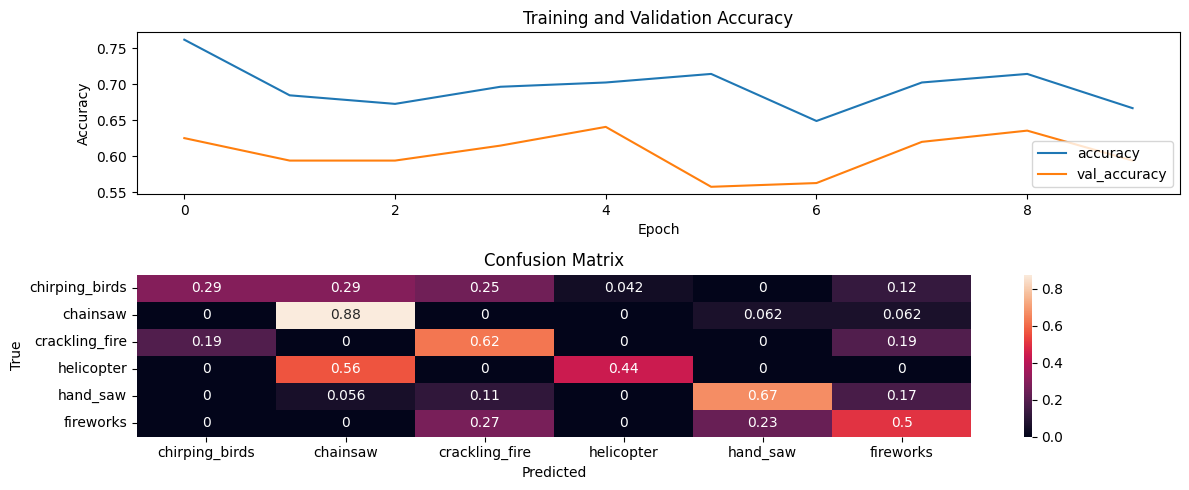

In [107]:
# train the model

history = model.fit(train_ds, validation_data=val_ds, epochs=10, use_multiprocessing=True, verbose = 1)

model.save(model_path)

# evaluate the model

loss, accuracy = model.evaluate(test_ds)

print(f'Test accuracy: {accuracy}')

# plot the confusion matrix

y_true = []
y_pred = []

for x, y, _ in test_ds:
  y_true.extend(y)
  y_pred.extend(model.predict(x).argmax(axis=1))
  
cm = confusion_matrix(y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

# plot the training history

fig, ax = plt.subplots(2, 1, figsize=(12, 5))

# Plot the training history
ax[0].plot(history.history['accuracy'], label='accuracy')
ax[0].plot(history.history['val_accuracy'], label='val_accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='lower right')
ax[0].set_title('Training and Validation Accuracy')

# Plot the confusion matrix
heatmap(cm, annot=True, xticklabels=my_classes, yticklabels=my_classes, ax=ax[1])
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')
ax[1].set_title('Confusion Matrix')

plt.tight_layout()
plt.show()

1/1 [==============================] - 0s 97ms/step
4.0
hand_saw
1/1 [==============================] - 0s 33ms/step
4.0
hand_saw
1/1 [==============================] - 0s 41ms/step
4.0
hand_saw
1/1 [==============================] - 0s 32ms/step
4.0
hand_saw
1/1 [==============================] - 0s 32ms/step
0.0
chirping_birds
1/1 [==============================] - 0s 27ms/step
0.0
chirping_birds
1/1 [==============================] - 0s 32ms/step
1.0
chainsaw
1/1 [==============================] - 0s 16ms/step
0.0
chirping_birds
1/1 [==============================] - 0s 34ms/step
0.0
chirping_birds


C:\Users\waric\AppData\Local\Temp\ipykernel_7428\1855498460.py:29: RuntimeWarning: invalid value encountered in divide
  cm = cm / cm.sum(axis=1)[:, np.newaxis]


Text(0.5, 1.0, 'Confusion Matrix')

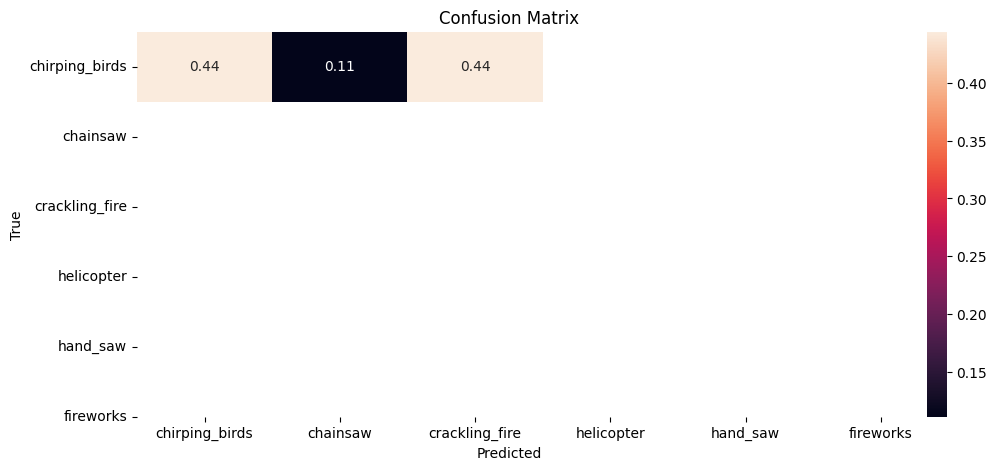

In [108]:
fm_dir = "classification/data/feature_matrices/"

file1 = np.load(fm_dir + "../melspecs/0005001a00.npy")
file2 = np.load(fm_dir + "../melspecs/0002001900.npy")
file3 = np.load(fm_dir + "../melspecs/0004001500.npy")
file4 = np.load(fm_dir + "../melspecs/0004001900.npy")
file5 = np.load(fm_dir + "../melspecs/0005000700.npy")
file6 = np.load(fm_dir + "../melspecs/0005001200.npy")
file7 = np.load(fm_dir + "../melspecs/0005002200.npy")
file8 = np.load(fm_dir + "../melspecs/0017002200.npy")
file9 = np.load(fm_dir + "../melspecs/0026000000.npy")

y_aug = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])

X_aug = [file1, file2, file3, file4, file5, file6, file7, file8, file9]


y_pred = np.zeros(len(y_aug))

for i in range(len(X_aug)):

    y_pred[i] = model.predict(X_aug[i]).argmax()
    print (y_pred[i])
    print (my_classes[int(y_pred[i])]) 

# Plot the confusion matrix

cm = confusion_matrix(y_aug, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

# Plot the confusion matrix

heatmap(cm, annot=True, xticklabels=my_classes, yticklabels=my_classes, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')
